**GRU**
---
* Bir RNN türüdür.LSTM'e göre daha basit yapıya sahiptir
* Uzun vadeli bağımlılıkları öğrenmede başarıldır
* Eğitimi daha hızlıdır

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0294 - val_loss: 0.0279
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0051 - val_loss: 0.0252
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053 - val_loss: 0.0251
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0048 - val_loss: 0.0300
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - val_loss: 0.0210
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0059 - val_loss: 0.0142
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0033 - val_loss: 0.0098
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - val_loss: 0.0155
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - val_loss: 0.0119
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0025 - val_loss: 0.0070
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028 - val_loss: 0.0117
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/s

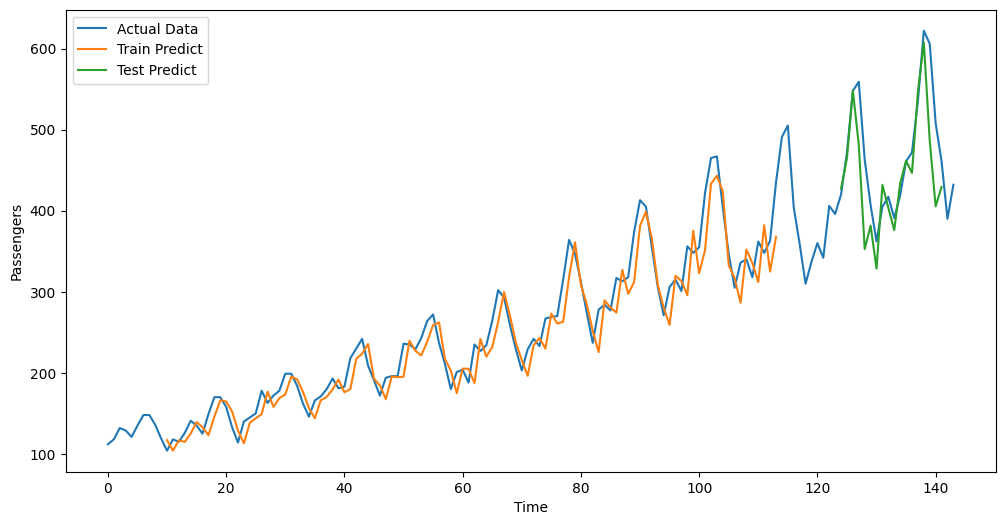

Train MAE: 19.77
Test MAE: 38.72
Train MSE: 645.11
Test MSE: 2234.62
Train RMSE: 25.40
Test RMSE: 47.27


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
import pickle

# Veriyi yükle
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, usecols=[1])
data = data.values.astype('float32')

# Veriyi 0 ile 1 arasında ölçekleyelim
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

# Veriyi eğitim ve test olarak ayırma (80% eğitim, 20% test)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# GRU modeli için veri şekillendirme
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 10
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Veriyi GRU girişine uygun hale getirme
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# GRU modeli oluşturma
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(50, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test))

# Tahminler
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Tahminleri ölçeklendirmeyi geri alma
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Gerçek değerleri ölçeklendirmeyi geri alma
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Eğitim ve test verisi için tahminleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(data, label='Actual Data')
plt.plot(range(time_step, len(train_predict) + time_step), train_predict, label='Train Predict')
plt.plot(range(len(train_predict) + (time_step * 2), len(train_predict) + (time_step * 2) + len(test_predict)), test_predict, label='Test Predict')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()

# Modeli kaydetme
model.save('air_passenger_gru_model.h5')

from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE, MSE ve RMSE hesaplama
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f'Train MAE: {train_mae:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Train MSE: {train_mse:.2f}')
print(f'Test MSE: {test_mse:.2f}')
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')